<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/EstimatingBaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating BAA 
## This notebook demonstrates how to build a machine learning model using Sklearn and applying that machine learning model to predictor surfaces to make estimates of basal area per acre (BAA). 
### Author: John Hogland 3/21/2023

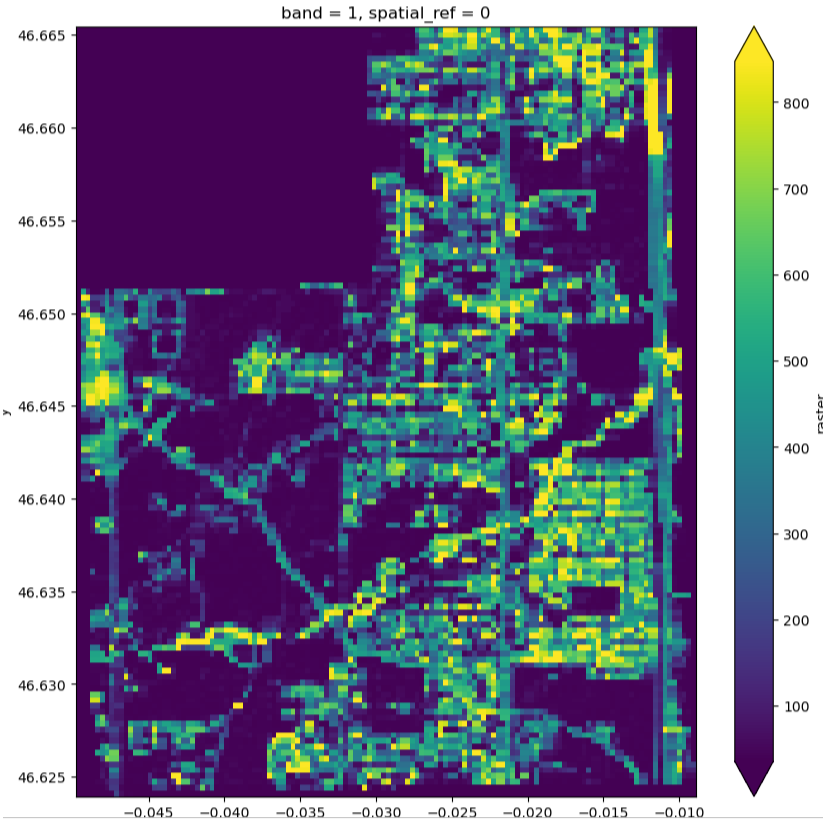!

## Install packages

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install plotly
!pip install laspy[lazrs,laszip]
!pip install raster_tools
!pip install stackstac
!pip install planetary_computer
!pip install pystac_client
!pip install leafmap xarray_leaflet
!pip install localtileserver

## Get supporting python file

In [ ]:
import gdown, zipfile

url='https://drive.google.com/file/d/1dy7bnPKc4BPvHlH-PkrObXwb-SW9nv7n/view?usp=sharing'
outfl= r'./rs_las.py'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

## The Process
### In this notebook we will be using derivatives from Lidar data acquired from Microsoft's Planetary Computer and the dataframe developed in the [SampleDesign](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/SampleDesign.ipynb) notebook to create a basal area per acre (BAA) random forest model and predict BAA mean estimates for each predictor raster cell. This notebooks builds upon the [Sample Design](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/SampleDesign.ipynb) and [Processing](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarProcessing.ipynb) notebooks at [Spatial Modeling Tutorials](https://github.com/jshogland/SpatialModelingTutorials).  


### Steps
1. Import python libraries
2. Open train.shp file and visualize 
3. Build a random forest model to predict BAA from Lidar predictor values
4. Apply BAA model to raster surfaces
5. Visualize BAA surface

## Step 1: Import libraries and get data
### Import libary

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import rs_las

import planetary_computer
import pystac_client
import requests
import stackstac

from dask.diagnostics import ProgressBar


from raster_tools import Raster, open_vectors, Vector, zonal

from shapely.geometry import shape
from shapely.ops import transform

import leafmap.leafmap as leafmap
from sklearn.ensemble import RandomForestRegressor


## Step 2: Open training shape file & visualize

In [ ]:
b_sample=open_vectors('./train.shp')
b_sample.data.compute().explore(color='orange')

## Step 3: Build Random Forest Model

In [ ]:
import pickle
import matplotlib.pyplot as plt
import pandas

gdf=b_sample.data.compute() #process data
X = gdf[['1','2','3','4','5','6','7','8','9','10','11']] #get just predictor dataframe
y = gdf[['BAA']] #get response dataframe

# build reandom forest model (use 66% of the data, select 4 features for each tree, 50 trees, store oob RMSE)
regr = RandomForestRegressor(max_features=4,n_estimators=50,max_samples=0.66,random_state=0,oob_score=True)
# fit the data and view oob
mdl=regr.fit(X, y)
print('Out of bag R squared = ' + str(mdl.oob_score_))

# store the model for later use open(path, 'wb')
pickle.dump(mdl,open('baa_rf_mdl.mdl','wb'))

# visualize importance graphs
imp=mdl.feature_importances_
v_imp = pandas.Series(imp, index=X.columns)
fig, ax = plt.subplots(figsize=(14,8))
std = np.std([tree.feature_importances_ for tree in mdl.estimators_], axis=0)
v_imp.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in MSE")
fig.tight_layout()

### Exercise 1: Build Random Forest Model with 3 features, 100 estimators, and 75% of the data¶

## Step 4: Apply model to predictor surfaces and save the BAA raster

In [ ]:
import xarray
from dask import array as da

# create predictor functions
def _pred_raster(xarr,mdl):
    b,y,x=xarr.shape
    vl_arr=np.moveaxis(xarr,0,-1).reshape(y*x,b)
    prd=mdl.predict(np.nan_to_num(vl_arr)).reshape(1,y,x)
    return prd

def predict_raster(pred_rs,mdl):
    ds_arr=pred_rs.xdata.data
    crds=pred_rs.xdata.coords
    chk=pred_rs.xdata.chunksizes
    ds_arr_out=da.map_blocks(_pred_raster,xarr=ds_arr,mdl=mdl,chunks=((1),chk['y'],chk['x']),meta=np.array((), dtype=float),dtype=float)
    xrs=xarray.DataArray(ds_arr_out,coords={'band':[1],'y':crds['y'],'x':crds['x']})
    rs=Raster(xrs).set_crs(pred_rs.crs)
    return rs

pred_rs=Raster('Lidar_30_metrics.tif')
pred_rs.xdata
est=predict_raster(pred_rs,mdl)
est.save('BAA.tif')
est.xdata

## Exercise 2:
- what is the difference between random forest model 1 and model 2 (Exercise 1) oob score?
- which one is better?

## Step 5: Visualize BAA surface

In [ ]:
#Specify the name of the predictor raster stack
outname='BAA.tif'

#Create a leafmap map object
m = leafmap.Map()

#Add ESRI's World imagery as a tile layer
m.add_tile_layer(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', name = 'Esri Imagery',attribution='ESRI')

#Add each band of the raster to the map object
m.add_raster(outname,bands=[1], layer_name='BAA (z)')

#show the map
m

# This ends the Estimate BAA notebook
## Check out the other notebooks:
- https://github.com/jshogland/SpatialModelingTutorials/tree/main/Notebooks
## References
- Spatial Modeling Notebooks:  https://github.com/jshogland/SpatialModelingTutorials
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html